In [1]:
# Import all necessary modules 
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import os
from numpy import asarray, save, load
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

In [15]:
# Load all the necessary modules
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score, recall_score, roc_auc_score, precision_score

## Chop Dataset into Bottom Half and Top Half

In [2]:
# Insert the desired path containing combined data files
path = os.path.expanduser(r"~/Documents/python/identification_modified_proteins/bin_size_0.01/")

# Change current working directory to the path given 
directory = os.chdir(path)

# Load data file 
loaded_data = np.load('all_train_data_0.01_with_2+.npy', allow_pickle=True)
df = pd.DataFrame(loaded_data)

# Chop the dataframe into two halves
bottom_half = df.iloc[:, :50649]
top_half = df.iloc[:, 50649:]

# Create feature and target arrays for both halves, bot = bottom
X_bot = bottom_half
X_top = top_half.drop(101300, axis=1) 
y = df[101300].astype('int') 

# Split into training and test set for bottom half
X_train_bot, X_test_bot, y_train, y_test = train_test_split(X_bot, y, test_size = 0.22, random_state=1, stratify=y)

# Split into training and test set for top half
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size = 0.22, random_state=1, stratify=y)

### Create Pipeline, Scoring & CV Parameters

In [16]:
# Setup a pipeline with a LR Classifier with adjusted hyperparameter settings
LR_pipe = Pipeline([
        ('reducer', PCA(n_components=2)),
        ('classifier', LogisticRegression(solver='lbfgs',penalty='l2',C=10,max_iter=500))])

# Define scoring parameters that will go into cross_validate
scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'roc_auc': 'roc_auc',
           'f1_score' : make_scorer(f1_score)}

# Set up repeated k-fold cross validation parameters
# Error if 10 or 5 splits; greater than the number of members in each class; only 11 in test set
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)

In [4]:
# Fit pipe to bottom half dataset training data
LR_pipe.fit(X_train_bot, y_train)

# Calculate the mean score from cross validation for bottom half
bot_val_score = cross_val_score(LR_pipe, X_bot, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
bot_val_std = cross_val_score(LR_pipe, X_bot, y, cv=cv, scoring="accuracy", n_jobs=-1).std()
bot_scores = cross_validate(LR_pipe, X_bot, y, cv=cv, scoring=scoring, n_jobs=-1)

# Fit pipe to bottom half dataset training data
LR_pipe.fit(X_train_top, y_train)

# Calculate the mean score from cross validation for top half
top_val_score = cross_val_score(LR_pipe, X_top, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
top_val_std = cross_val_score(LR_pipe, X_top, y, cv=cv, scoring="accuracy", n_jobs=-1).std()
top_scores = cross_validate(LR_pipe,X_top, y, cv=cv, scoring=scoring, n_jobs=-1)

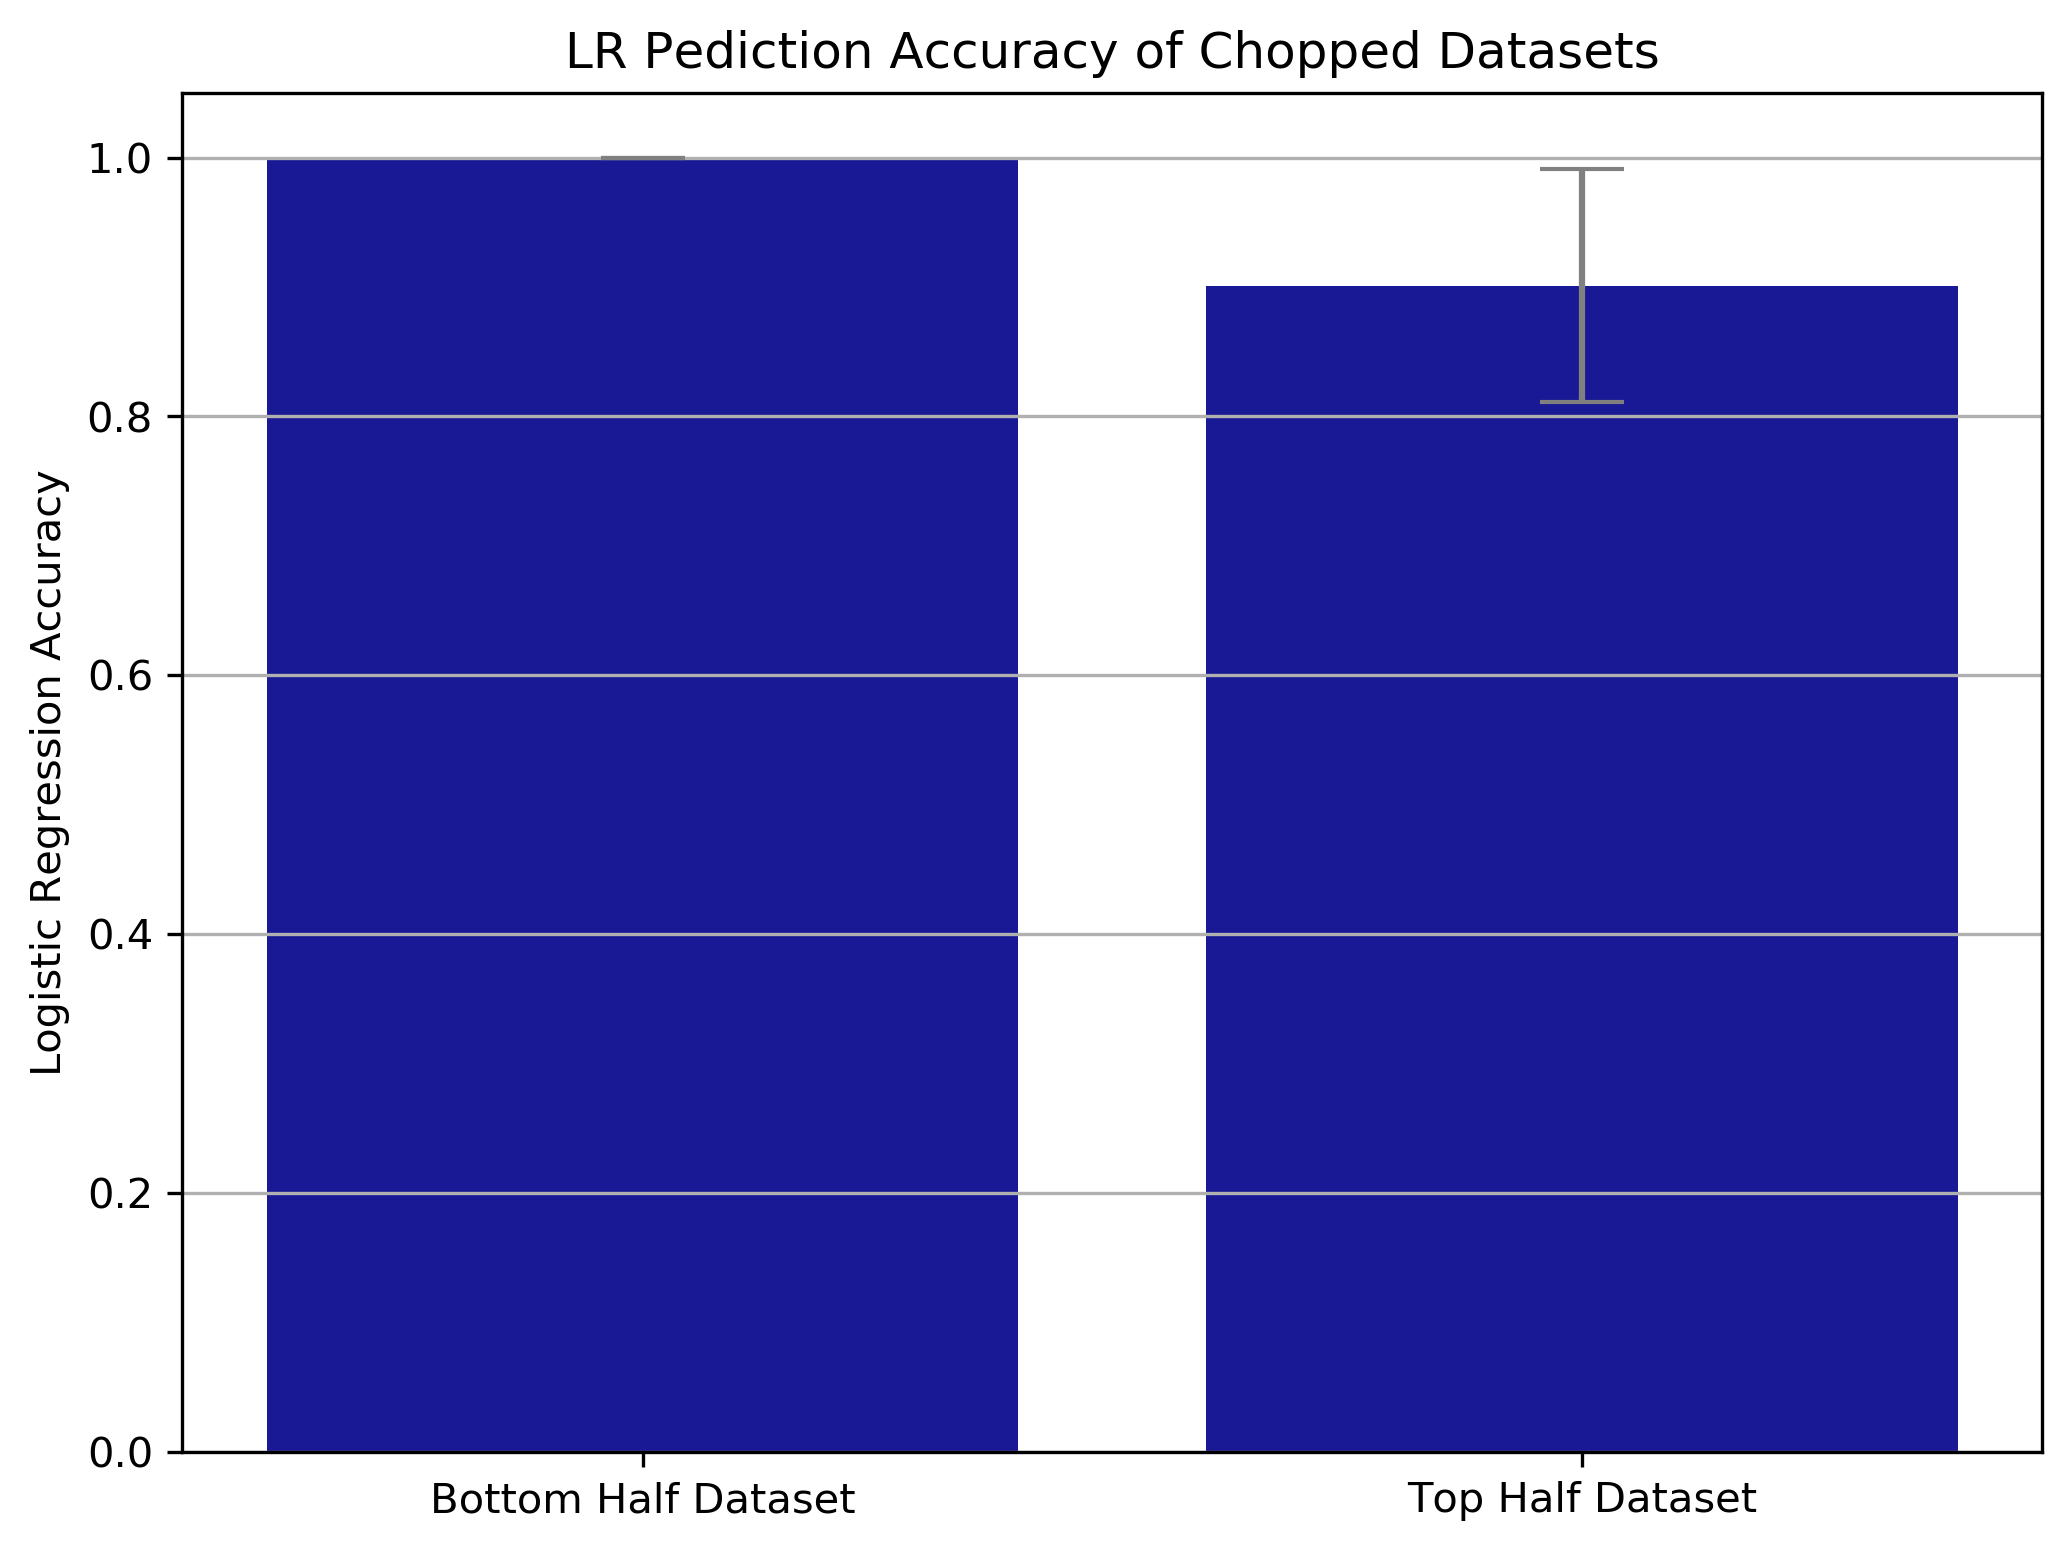

In [7]:
# Assign data variables that will input into bar chart. 
x_labels = ['Bottom Half Dataset', 'Top Half Dataset']
x_pos = np.arange(len(x_labels))
scores = [bot_val_score, top_val_score]
error = [bot_val_std, top_val_std] 

# Build bar chart of socres.
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
ax.bar(x_pos, scores, yerr=error, align='center', color='darkblue', alpha=0.9, ecolor='grey', capsize=10)
ax.set_ylabel('Logistic Regression Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_title('LR Pediction Accuracy of Chopped Datasets')
ax.yaxis.grid(True) 
plt.show()

In [9]:
data = {'Bottom Half of Dataset': bot_scores['test_accuracy'], 'Top Half of Dataset': top_scores['test_accuracy']}
df = pd.DataFrame(data)
df

,Bottom Half of Dataset,Top Half of Dataset
0,1.0,0.875000
1,1.0,0.933333
2,1.0,1.000000
3,1.0,0.937500
4,1.0,0.933333
5,1.0,0.933333
6,1.0,1.000000
7,1.0,1.000000
8,1.0,0.733333
9,1.0,0.750000


In [17]:
# Use the cross_validate function to see what happens in each fold
b_validate = cross_validate(LR_pipe, X_bot, y, cv=cv, scoring=scoring, n_jobs=-1)

# Use the cross_validate function to see what happens in each fold
t_validate = cross_validate(LR_pipe, X_top, y, cv=cv, scoring=scoring, n_jobs=-1)

# Extract the specific values from the cross validation of the test set
b_accuracy = np.mean(b_validate['test_accuracy']), np.std(b_validate['test_accuracy'])
b_fit_time = np.mean(b_validate['fit_time']), np.std(b_validate['fit_time'])
b_score_time = np.mean(b_validate['score_time']), np.std(b_validate['score_time'])
b_roc_auc = np.mean(b_validate['test_roc_auc']), np.std(b_validate['test_roc_auc'])
b_f1 = np.mean(b_validate['test_f1_score']), np.std(b_validate['test_f1_score'])

# Extract the specific values from the cross validation of the test set
t_accuracy = np.mean(t_validate['test_accuracy']), np.std(t_validate['test_accuracy'])
t_fit_time = np.mean(t_validate['fit_time']), np.std(t_validate['fit_time'])
t_score_time = np.mean(t_validate['score_time']), np.std(t_validate['score_time'])
t_roc_auc = np.mean(t_validate['test_roc_auc']), np.std(t_validate['test_roc_auc'])
t_f1 = np.mean(t_validate['test_f1_score']), np.std(t_validate['test_f1_score'])

# Report Performance
print('=== Logistic Regression Bottom Half Scores ===')
print('Average Test Accuracy: %.3f (%.3f)' % (b_accuracy))
print('Average Fit Time: %.3f (%.3f)' % (b_fit_time))
print('Average Score Time: %.3f (%.3f)' % (b_score_time))
print('Average Fit Test ROC & AUC: %.3f (%.3f)' % (b_roc_auc))
print('Average F1 Score: %.3f (%.3f)' % (b_f1))
print('\n')
print('=== Logistic Regression Top Half Scores ===')
print('Average Test Accuracy: %.3f (%.3f)' % (t_accuracy))
print('Average Fit Time: %.3f (%.3f)' % (t_fit_time))
print('Average Score Time: %.3f (%.3f)' % (t_score_time))
print('Average Fit Test ROC & AUC: %.3f (%.3f)' % (t_roc_auc))
print('Average F1 Score: %.3f (%.3f)' % (t_f1))
print('\n')

=== Logistic Regression Bottom Half Scores ===
Average Test Accuracy: 1.000 (0.000)
Average Fit Time: 1.082 (0.376)
Average Score Time: 0.396 (0.140)
Average Fit Test ROC & AUC: 1.000 (0.000)
Average F1 Score: 1.000 (0.000)


=== Logistic Regression Top Half Scores ===
Average Test Accuracy: 0.901 (0.090)
Average Fit Time: 0.564 (0.066)
Average Score Time: 0.236 (0.049)
Average Fit Test ROC & AUC: 0.955 (0.062)
Average F1 Score: 0.832 (0.178)


